# Quantum Key Distribution 

In [1]:
import numpy as np
import random
import re
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.tools.visualization import circuit_drawer, plot_histogram

### 1. Singlet States

In [2]:
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

In [3]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

### 2. Measurement

In [4]:
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.s(qr[0])
measureA2.h(qr[0])
measureA2.t(qr[0])
measureA2.h(qr[0])
measureA2.measure(qr[0],cr[0])

measureA3 = QuantumCircuit(qr, cr, name='measureA3')
measureA3.measure(qr[0],cr[0])

measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.s(qr[1])
measureB1.h(qr[1])
measureB1.t(qr[1])
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.tdg(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1],cr[1])

aliceMeasurements = [measureA1, measureA2, measureA3]
bobMeasurements = [measureB1, measureB2, measureB3]

In [5]:
numberOfSinglets = 500

In [6]:
aliceMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] 
bobMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)]

In [7]:
circuits = [] 

for i in range(numberOfSinglets):
    circuitName = str(i) + ':A' + str(aliceMeasurementChoices[i]) + '_B' + str(bobMeasurementChoices[i])
    circuitName = singlet + aliceMeasurements[aliceMeasurementChoices[i]-1] + bobMeasurements[bobMeasurementChoices[i]-1]   
    circuits.append(circuitName)

<ipython-input-7-6584e906c89a>:5: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuitName = singlet + aliceMeasurements[aliceMeasurementChoices[i]-1] + bobMeasurements[bobMeasurementChoices[i]-1]
C:\Users\arkou\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


In [8]:
print(circuits[0].name)

circuit-8


### 3. Result Compilation

In [9]:
backend=BasicAer.get_backend('qasm_simulator')
result = execute(circuits, backend=backend, shots=1).result()  

In [10]:
result.get_counts(circuits[0])

{'0011': 1}

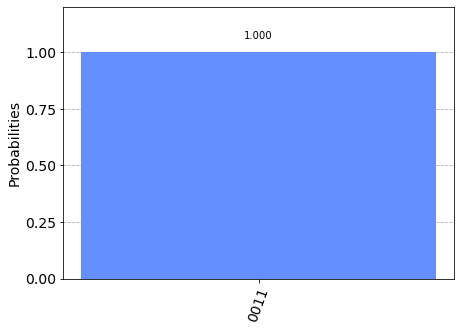

In [11]:
plot_histogram(result.get_counts(circuits[0]))

In [12]:
abPatterns = [
    re.compile('..00$'), 
    re.compile('..01$'), 
    re.compile('..10$'), 
    re.compile('..11$') 
]

In [13]:
aliceResults = [] 
bobResults = [] 

for i in range(numberOfSinglets):
    res = list(result.get_counts(circuits[i]).keys())[0] 
    if abPatterns[0].search(res): 
        aliceResults.append(-1) 
        bobResults.append(-1) 
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): 
        aliceResults.append(-1) 
        bobResults.append(1)
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

### 4. Base Reveal

In [14]:
aliceKey = [] 
bobKey = [] 

for i in range(numberOfSinglets):
    if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 2):
        aliceKey.append(aliceResults[i]) 
        bobKey.append(- bobResults[i]) 
        
keyLength = len(aliceKey)

In [15]:
abKeyMismatches = 0

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]:
        abKeyMismatches += 1

### 5. CHSH Correlation Value Test

In [16]:
def chsh_corr(result):    
    countA1B1 = [0, 0, 0, 0] 
    countA1B3 = [0, 0, 0, 0] 
    countA3B1 = [0, 0, 0, 0] 
    countA3B3 = [0, 0, 0, 0] 

    for i in range(numberOfSinglets):
        res = list(result.get_counts(circuits[i]).keys())[0]
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B1[j] += 1

        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B3[j] += 1

        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B1[j] += 1
                    
        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B3[j] += 1
                    
    total11 = sum(countA1B1)
    total13 = sum(countA1B3)
    total31 = sum(countA3B1)
    total33 = sum(countA3B3)      
                    
    expect11 = (countA1B1[0] - countA1B1[1] - countA1B1[2] + countA1B1[3])/total11 
    expect13 = (countA1B3[0] - countA1B3[1] - countA1B3[2] + countA1B3[3])/total13 
    expect31 = (countA3B1[0] - countA3B1[1] - countA3B1[2] + countA3B1[3])/total31 
    expect33 = (countA3B3[0] - countA3B3[1] - countA3B3[2] + countA3B3[3])/total33 
    
    corr = expect11 - expect13 + expect31 + expect33  
    return corr

In [17]:
corr = chsh_corr(result)

print('CHSH correlation value: ' + str(round(corr, 3)))
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches))

CHSH correlation value: -2.589
Length of the key: 114
Number of mismatching bits: 0


### 6. Eavesdropping Simulation

In [18]:
measureEA2 = QuantumCircuit(qr, cr, name='measureEA2')
measureEA2.s(qr[0])
measureEA2.h(qr[0])
measureEA2.t(qr[0])
measureEA2.h(qr[0])
measureEA2.measure(qr[0],cr[2])

measureEA3 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA3.measure(qr[0],cr[2])

measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.s(qr[1])
measureEB1.h(qr[1])
measureEB1.t(qr[1])
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

eveMeasurements = [measureEA2, measureEA3, measureEB1, measureEB2]

In [19]:
eveMeasurementChoices = []

for j in range(numberOfSinglets):      
    if random.uniform(0, 1) <= 0.5: 
        eveMeasurementChoices.append([0, 2])
    else: 
        eveMeasurementChoices.append([1, 3])

In [20]:
circuits = [] 

for j in range(numberOfSinglets):
    circuitName = str(j) + ':A' + str(aliceMeasurementChoices[j]) + '_B' + str(bobMeasurementChoices[j] + 2) + '_E' + str(eveMeasurementChoices[j][0]) + str(eveMeasurementChoices[j][1] - 1)
    circuitName = singlet + eveMeasurements[eveMeasurementChoices[j][0]-1] + eveMeasurements[eveMeasurementChoices[j][1]-1] + aliceMeasurements[aliceMeasurementChoices[j]-1] +  bobMeasurements[bobMeasurementChoices[j]-1]    
    circuits.append(circuitName)

In [21]:
backend=BasicAer.get_backend('qasm_simulator')
result = execute(circuits, backend=backend, shots=1).result()

In [22]:
print(str(circuits[0].name) + '\t' + str(result.get_counts(circuits[0])))

circuit-4910	{'0101': 1}


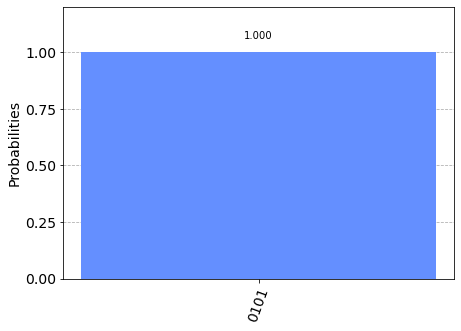

In [23]:
plot_histogram(result.get_counts(circuits[0]))

In [24]:
ePatterns = [
    re.compile('00..$'), 
    re.compile('01..$'),
    re.compile('10..$'),
    re.compile('11..$')  
]

In [25]:
aliceResults = [] 
bobResults = [] 

eveResults = [] 

for j in range(numberOfSinglets):
    
    res = list(result.get_counts(circuits[j]).keys())[0] 
    
    if abPatterns[0].search(res): 
        aliceResults.append(-1) 
        bobResults.append(-1) 
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): 
        aliceResults.append(-1) 
        bobResults.append(1) 
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

    if ePatterns[0].search(res): 
        eveResults.append([-1, -1]) 
    if ePatterns[1].search(res):
        eveResults.append([1, -1])
    if ePatterns[2].search(res):
        eveResults.append([-1, 1])
    if ePatterns[3].search(res):
        eveResults.append([1, 1])

In [26]:
aliceKey = [] 
bobKey = [] 
eveKeys = [] 

for j in range(numberOfSinglets):
    if (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 3 and bobMeasurementChoices[j] == 2):  
        aliceKey.append(aliceResults[j]) 
        bobKey.append(-bobResults[j]) 
        eveKeys.append([eveResults[j][0], -eveResults[j][1]]) 

keyLength = len(aliceKey) 

In [27]:
abKeyMismatches = 0 
eaKeyMismatches = 0 
ebKeyMismatches = 0 

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]: 
        abKeyMismatches += 1
    if eveKeys[j][0] != aliceKey[j]:
        eaKeyMismatches += 1
    if eveKeys[j][1] != bobKey[j]:
        ebKeyMismatches += 1

In [28]:
eaKnowledge = (keyLength - eaKeyMismatches)/keyLength 
ebKnowledge = (keyLength - ebKeyMismatches)/keyLength 

In [29]:
corr = chsh_corr(result)

In [30]:
print('CHSH correlation value: ' + str(round(corr, 3)) + '\n')

print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

CHSH correlation value: -1.497

Length of the key: 114
Number of mismatching bits: 15

Eve's knowledge of Alice's key: 92.11 %
Eve's knowledge of Bob's key: 94.74 %
